In [1]:
%pylab inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
from IPython.display import clear_output
import time
import numpy as np
import math
import gym

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.display import clear_output
import random
import time
from copy import deepcopy

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K
from keras.layers import Lambda
from keras.utils.np_utils import to_categorical   

In [4]:
import myfrozen

In [5]:
from gym.envs.registration import register, spec

In [6]:
import h5py
from keras.models import load_model

In [7]:
def make_environment(name,seed,rowindex,colindex):
    register(
            id=name,
            entry_point='myfrozen.fl_custom:FrozenLakeEnv',
            kwargs={'map_name': '8x8', 'is_slippery': False,
            'seed': seed, 'rowindex': rowindex, 'colindex': colindex},
            timestep_limit=100,
            reward_threshold=0.78,
            )
    env = gym.make(name)
    return env

In [10]:
iteration = 8
name='FO8x8-v%d' % iteration
env = make_environment(name,iteration,5,0)
env.render()


FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF


In [12]:
toy=ACTOR_CRITIC(env=env,warm_start=0)
policy = toy.sample_generator(1)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 260       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 260       
_________________________________________________________________
activation_3

/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[[u'v' u'v' u'<' u'<' u'v' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'v' u'<' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'<' u'<' u'v' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'v' u'<' u'v' u'v' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'v' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'^' u'<' u'<']]


/anaconda/envs/drl/lib/python2.7/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## The actor

In [30]:
class ACTOR_CRITIC():
    def __init__(self,env,warm_start):
        self.env = env
        self.warm_start = warm_start
        self.OBSERVATION_SPACE = self.env.observation_space.n
        self.ACTION_SPACE = self.env.action_space.n
        # Build the critic
        self.critic_model = self.build_critic()
        # Build the actor
        self.actor_model = self.build_actor()
        # Recover the generator
        self.generator = load_model('models/policies/generator.h5')
        
    def build_actor(self):
        actor_model = Sequential()
        actor_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform', input_shape=(self.OBSERVATION_SPACE,)))
        actor_model.add(Activation('relu'))
        actor_model.add(Dense(128, init='lecun_uniform'))
        actor_model.add(Activation('relu'))
        actor_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform'))
        actor_model.add(Activation('linear'))
        
        actor_model.summary()

        return actor_model

    
    def build_critic(self):
        critic_model = Sequential()
        critic_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform', input_shape=(self.OBSERVATION_SPACE,)))
        critic_model.add(Activation('relu'))
        critic_model.add(Dense(1, init='lecun_uniform'))
        critic_model.add(Activation('linear'))
        
        critic_model.summary()

        return critic_model
    
    def trainer(self,epochs=1000,batchSize=30,gamma=0.975,epsilon=1,min_epsilon=0.1,buffer=40,policy=0):
        
        wins = 0
        losses = 0
        # Replay buffers
        actor_replay = []
        critic_replay = []
        
        wins_ws = 0
        losses_ws = 0
        #warm_start=self.warm_start
        
        optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        
        self.actor_model.compile(loss='mse', optimizer=optimizer)
        self.critic_model.compile(loss='mse', optimizer=optimizer)
        
        #policy = self.sample_generator(1)
        
        OBS_SQR = int(math.sqrt(self.OBSERVATION_SPACE))
        STATEGRID = np.zeros((OBS_SQR,OBS_SQR))
        
        self.env.reset()
        self.env.render()
        self.plot_value(STATEGRID)
        
        for i in range(epochs):

            observation = self.env.reset()
            done = False
            reward = 0
            info = None
            move_counter = 0

            while(not done):
                # Get original state, original reward, and critic's value for this state.
                orig_state = self.to_onehot(self.OBSERVATION_SPACE,observation)
                orig_reward = reward
                orig_val = self.critic_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))

                if (random.random() < epsilon): #choose random action
                    action = np.random.randint(0,self.ACTION_SPACE)
                else: #choose best action from Q(s,a) values
                    if i < self.warm_start:
                        obs_predict = np.squeeze(orig_state)
                        index, = np.where(obs_predict == 1.)
                        qval = self.actor_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))
                        action = np.argmax(policy[index,:])
                        #action = np.argmax(policy[index,:])
                    else:
                        qval = self.actor_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))
                        action = (np.argmax(qval))
                
                #Take action, observe new state S'
                new_observation, new_reward, done, info = self.env.step(action)
                new_state = self.to_onehot(self.OBSERVATION_SPACE,new_observation)
                # Critic's value for this new state.
                new_val = self.critic_model.predict(new_state.reshape(1,self.OBSERVATION_SPACE))
            
                if not done: # Non-terminal state.
                    target = orig_reward + ( gamma * new_val)
                else:
                    # In terminal states, the environment tells us
                    # the value directly.
                    target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
                if new_reward <0:
                    best_val = new_reward
                else:
                    best_val = max((orig_val*gamma), target)
                # Now append this to our critic replay buffer.
                critic_replay.append([orig_state, best_val])
                # If we are in a terminal state, append a replay for it also.
                if done:
                    critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
                actor_delta = new_val - orig_val                
                actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
                while(len(critic_replay) > buffer): # Trim replay buffer
                    critic_replay.pop(0)
            # Start training when we have enough samples.
                if(len(critic_replay) >= buffer):
                    minibatch = random.sample(critic_replay, batchSize)
                    X_train = []
                    y_train = []
                    for memory in minibatch:
                        m_state, m_value = memory
                        y = np.empty([1])
                        y[0] = m_value
                        X_train.append(m_state.reshape((self.OBSERVATION_SPACE,)))
                        y_train.append(y.reshape((1,)))
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)
                    self.critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
                # Actor Replays...
                while(len(actor_replay) > buffer):
                    actor_replay.pop(0)                
                if(len(actor_replay) >= buffer):
                    X_train = []
                    y_train = []
                    minibatch = random.sample(actor_replay, batchSize)
                    for memory in minibatch:
                        m_orig_state, m_action, m_value = memory
                        old_qval = self.actor_model.predict( m_orig_state.reshape(1,self.OBSERVATION_SPACE,) )
                        y = np.zeros(( 1, self.ACTION_SPACE ))
                        y[:] = old_qval[:]
                        y[0][m_action] = m_value
                        X_train.append(m_orig_state.reshape((self.OBSERVATION_SPACE,)))
                        y_train.append(y.reshape((self.ACTION_SPACE,)))
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)
                    self.actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

                # Bookkeeping at the end of the turn.
                observation = new_observation
                reward = new_reward
                move_counter+=1
                if done:
                    if new_reward > 0 : # Win
                        wins += 1
                    else: # Loss
                        losses += 1
            if i == (self.warm_start-1):
                wins_ws = deepcopy(wins)
                losses_ws = deepcopy(losses)
            # Finised Epoch
            clear_output(wait=True)
            print("Game #: %s" % (i,))
            print("Moves this round %s" % move_counter)
            print("Final Position:")
            self.env.render()
            print("Wins/Losses %s/%s" % (wins, losses))
            print("Wins/Losses before WS %s/%s" % (wins_ws, losses_ws))
            if epsilon > min_epsilon:
                epsilon -= (1.0/epochs)
                
        self.plot_value(STATEGRID)
        return self.actor_model, self.critic_model
        
    def to_onehot(self,size,value):
        my_onehot = np.zeros((size))
        my_onehot[value] = 1.0
        return my_onehot
    
    def show_policy(self,q):
        A2A=['<','v','>','^']
        grid = np.zeros(self.OBSERVATION_SPACE, dtype='<U2')
        for index in xrange(self.OBSERVATION_SPACE):
            action = np.argmax(q[index,:])
            grid[index] = A2A[action]
        grid = np.reshape(grid, (8, 8), order='C')
        print(grid)
        return grid
    
    def sample_generator(self,trials):
        for iteration in range(trials):
            noise = np.random.normal(0, 1, (1, self.OBSERVATION_SPACE))
            gen_imgs = self.generator.predict(noise)
            gen_imgs = np.squeeze(gen_imgs, axis=0)
            _ = self.show_policy(gen_imgs)
        return gen_imgs
    
    def plot_value(self,initial_state):
        obs_sqr = int(math.sqrt(self.OBSERVATION_SPACE))
        np_w_cri_r = np.zeros((obs_sqr,obs_sqr))
        working_state = initial_state.copy()
        for x in range(0,obs_sqr):
            for y in range(0,obs_sqr):
                my_state = working_state.copy()
                my_state[x,y] = 1
                value = self.critic_model.predict(my_state.reshape(1, self.OBSERVATION_SPACE))
                np_w_cri_r[x,y] = value
        np_w_cri_r.shape
        pylab.pcolor(np_w_cri_r)
        pylab.title("Value Network")
        pylab.colorbar()
        pylab.xlabel("X")
        pylab.ylabel("Y")
        pylab.gca().invert_yaxis()
        pylab.draw()

In [80]:
class ACTOR_CRITIC():
    def __init__(self,env,warm_start):
        self.env = env
        self.warm_start = warm_start
        self.OBSERVATION_SPACE = self.env.observation_space.n
        self.ACTION_SPACE = self.env.action_space.n
        # Build the critic
        self.critic_model = self.build_critic()
        # Build the actor
        self.actor_model = self.build_actor()
        # Recover the generator
        self.generator = load_model('models/policies/generator.h5')
        # Recover the discriminator
        self.discriminator = load_model('models/policies/discriminator.h5')
        
    def build_actor(self):
        actor_model = Sequential()
        actor_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform', input_shape=(self.OBSERVATION_SPACE,)))
        actor_model.add(Activation('relu'))
        actor_model.add(Dense(128, init='lecun_uniform'))
        actor_model.add(Activation('relu'))
        actor_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform'))
        actor_model.add(Activation('linear'))
        
        actor_model.summary()
        
        #a_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        #actor_model.compile(loss='mse', optimizer=a_optimizer)

        return actor_model

    
    def build_critic(self):
        critic_model = Sequential()
        critic_model.add(Dense(self.ACTION_SPACE, init='lecun_uniform', input_shape=(self.OBSERVATION_SPACE,)))
        critic_model.add(Activation('relu'))
        critic_model.add(Dense(1, init='lecun_uniform'))
        critic_model.add(Activation('linear'))
        
        critic_model.summary()
        
        #c_optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        #critic_model.compile(loss='mse', optimizer=c_optimizer)

        return critic_model
    
    def trainer(self,epochs=1000,batchSize=30,gamma=0.975,epsilon=1,min_epsilon=0.1,buffer=40,policy=0):
        
        wins = 0
        losses = 0
        # Replay buffers
        actor_replay = []
        critic_replay = []
        
        wins_ws = 0
        losses_ws = 0
        #warm_start=self.warm_start
        
        optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        
        self.actor_model.compile(loss='mse', optimizer=optimizer)
        self.critic_model.compile(loss='mse', optimizer=optimizer)
        
        #policy = self.sample_generator(1)
        
        OBS_SQR = int(math.sqrt(self.OBSERVATION_SPACE))
        STATEGRID = np.zeros((OBS_SQR,OBS_SQR))
        
        self.env.reset()
        self.env.render()
        self.plot_value(STATEGRID)
        
        previous_policy = np.reshape(np.ones(64),(8,8))
        
        for i in range(epochs):

            observation = self.env.reset()
            done = False
            reward = 0
            info = None
            move_counter = 0
            
            policy_done = self.play()
            current_policy = self.show_policy_actor()
            
            norm = self.compute_norm(previous_policy,current_policy)
            print(norm)
            if policy_done == True and norm == 0.0:
                print("Converged")
                break
            
            #if policy_done == True:
            #    print("Policy Done")
            #    break

            while(not done):
                # Get original state, original reward, and critic's value for this state.
                orig_state = self.to_onehot(self.OBSERVATION_SPACE,observation)
                orig_reward = reward
                orig_val = self.critic_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))

                if (random.random() < epsilon): #choose random action
                    action = np.random.randint(0,self.ACTION_SPACE)
                else: #choose best action from Q(s,a) values
                    if i < self.warm_start:
                        obs_predict = np.squeeze(orig_state)
                        index, = np.where(obs_predict == 1.)
                        qval = self.actor_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))
                        action = np.argmax(policy[index,:])
                        #action = np.argmax(policy[index,:])
                    else:
                        qval = self.actor_model.predict(orig_state.reshape(1,self.OBSERVATION_SPACE))
                        action = (np.argmax(qval))
                
                #Take action, observe new state S'
                new_observation, new_reward, done, info = self.env.step(action)
                new_state = self.to_onehot(self.OBSERVATION_SPACE,new_observation)
                # Critic's value for this new state.
                new_val = self.critic_model.predict(new_state.reshape(1,self.OBSERVATION_SPACE))
            
                if not done: # Non-terminal state.
                    target = orig_reward + ( gamma * new_val)
                else:
                    # In terminal states, the environment tells us
                    # the value directly.
                    target = orig_reward + ( gamma * new_reward )
            
            # For our critic, we select the best/highest value.. The
            # value for this state is based on if the agent selected
            # the best possible moves from this state forward.
            # 
            # BTW, we discount an original value provided by the
            # value network, to handle cases where its spitting
            # out unreasonably high values.. naturally decaying
            # these values to something reasonable.
                if new_reward <0:
                    best_val = new_reward
                else:
                    best_val = max((orig_val*gamma), target)
                # Now append this to our critic replay buffer.
                critic_replay.append([orig_state, best_val])
                # If we are in a terminal state, append a replay for it also.
                if done:
                    critic_replay.append( [new_state, float(new_reward)] )
            
            # Build the update for the Actor. The actor is updated
            # by using the difference of the value the critic
            # placed on the old state vs. the value the critic
            # places on the new state.. encouraging the actor
            # to move into more valuable states.
                actor_delta = new_val - orig_val                
                actor_replay.append([orig_state, action, actor_delta])
                    
            # Critic Replays...
                while(len(critic_replay) > buffer): # Trim replay buffer
                    critic_replay.pop(0)
            # Start training when we have enough samples.
                if(len(critic_replay) >= buffer):
                    minibatch = random.sample(critic_replay, batchSize)
                    X_train = []
                    y_train = []
                    for memory in minibatch:
                        m_state, m_value = memory
                        y = np.empty([1])
                        y[0] = m_value
                        X_train.append(m_state.reshape((self.OBSERVATION_SPACE,)))
                        y_train.append(y.reshape((1,)))
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)
                    self.critic_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
            
                # Actor Replays...
                while(len(actor_replay) > buffer):
                    actor_replay.pop(0)                
                if(len(actor_replay) >= buffer):
                    X_train = []
                    y_train = []
                    minibatch = random.sample(actor_replay, batchSize)
                    for memory in minibatch:
                        m_orig_state, m_action, m_value = memory
                        old_qval = self.actor_model.predict( m_orig_state.reshape(1,self.OBSERVATION_SPACE,) )
                        y = np.zeros(( 1, self.ACTION_SPACE ))
                        y[:] = old_qval[:]
                        y[0][m_action] = m_value
                        X_train.append(m_orig_state.reshape((self.OBSERVATION_SPACE,)))
                        y_train.append(y.reshape((self.ACTION_SPACE,)))
                    X_train = np.array(X_train)
                    y_train = np.array(y_train)
                    self.actor_model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)

                # Bookkeeping at the end of the turn.
                observation = new_observation
                reward = new_reward
                move_counter+=1
                if done:
                    if new_reward > 0 : # Win
                        wins += 1
                    else: # Loss
                        losses += 1
            if i == (self.warm_start-1):
                wins_ws = deepcopy(wins)
                losses_ws = deepcopy(losses)
            # Finised Epoch
            
            if i == 500 and wins < wins_threshold:
                skip = True
                break
            clear_output(wait=True)
            print("Game #: %s" % (i,))
            print("Moves this round %s" % move_counter)
            print("Final Position:")
            self.env.render()
            print("Wins/Losses %s/%s" % (wins, losses))
            print("Wins/Losses before WS %s/%s" % (wins_ws, losses_ws))
            if epsilon > min_epsilon:
                epsilon -= (1.0/epochs)
                
            previous_policy = current_policy
        #self.plot_value(STATEGRID)
        return self.actor_model, self.critic_model
        
    def to_onehot(self,size,value):
        my_onehot = np.zeros((size))
        my_onehot[value] = 1.0
        return my_onehot
    
    def show_policy(self,q):
        A2A=['<','v','>','^']
        grid = np.zeros(self.OBSERVATION_SPACE, dtype='<U2')
        for index in xrange(self.OBSERVATION_SPACE):
            action = np.argmax(q[index,:])
            grid[index] = A2A[action]
        grid = np.reshape(grid, (8, 8), order='C')
        return grid
    
    def compute_probability(self):
        catlabels = to_categorical(self.make_policy(), num_classes=4)
        return self.discriminator.predict(np.expand_dims(catlabels,axis=0))[0][0]
        
    def make_policy(self):
        initial_state = np.zeros(64)
        grid = np.zeros(64)
        for x in range(0,64):
            my_state = initial_state.copy()
            my_state[x] = 1
            obs_predict = my_state.reshape(1,64,)
            qval = self.actor_model.predict(obs_predict)
            action = (np.argmax(qval))
            grid[x] = action
        print(grid)
        return grid
        
    def show_policy_actor(self):
        initial_state = np.zeros((8,8))
        A2A=['<','v','>','^']
        grid = np.zeros((8,8), dtype='<U2')
        gridnum = np.zeros((8,8))
        for x in range(0,8):
            for y in range(0,8):
                my_state = initial_state.copy()
                my_state[x,y] = 1
                obs_predict = my_state.reshape(1,64,)
                qval = self.actor_model.predict(obs_predict)
                action = (np.argmax(qval))
                gridnum[x,y] = action
                grid[x,y] = A2A[action]
        print(grid)
        print(gridnum)
        return gridnum
    
    def sample_generator(self,trials):
        for iteration in range(trials):
            noise = np.random.normal(0, 1, (1, self.OBSERVATION_SPACE))
            gen_imgs = self.generator.predict(noise)
            gen_imgs = np.squeeze(gen_imgs, axis=0)
            _ = self.show_policy(gen_imgs)
        return gen_imgs
    
    def plot_value(self,initial_state):
        obs_sqr = int(math.sqrt(self.OBSERVATION_SPACE))
        np_w_cri_r = np.zeros((obs_sqr,obs_sqr))
        working_state = initial_state.copy()
        for x in range(0,obs_sqr):
            for y in range(0,obs_sqr):
                my_state = working_state.copy()
                my_state[x,y] = 1
                value = self.critic_model.predict(my_state.reshape(1, self.OBSERVATION_SPACE))
                np_w_cri_r[x,y] = value
        np_w_cri_r.shape
        pylab.pcolor(np_w_cri_r)
        pylab.title("Value Network")
        pylab.colorbar()
        pylab.xlabel("X")
        pylab.ylabel("Y")
        pylab.gca().invert_yaxis()
        pylab.draw()
    
    def play(self,render_every_step=False):
        policy_done = False
        observation = self.env.reset()
        done = False
        reward = 0.0
        max_moves = 40
        move_counter = 0
        while not done and move_counter < max_moves:
            state = self.to_onehot(self.OBSERVATION_SPACE,observation)
            qval = self.actor_model.predict(state.reshape(1,self.OBSERVATION_SPACE))
            action = (np.argmax(qval))
            observation, reward, done, info = self.env.step(action)
            if render_every_step:
                env.render()
            move_counter += 1
        if reward==1.0:
            policy_done = True
            print("Goal reached!")
        return policy_done
    
    def compute_norm(self,previous,current):
        return np.linalg.norm(previous-current,'fro')

In [81]:
actor_critic=ACTOR_CRITIC(env=env,warm_start=0)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_71 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 5         
_________________________________________________________________
activation_72 (Activation)   (None, 1)                 0         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_7

Game #: 657
Moves this round 1
Final Position:
  (Right)
FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF
Wins/Losses 32/626
Wins/Losses before WS 0/0
Goal reached!
[[u'<' u'v' u'<' u'<' u'<' u'^' u'v' u'v']
 [u'v' u'v' u'<' u'^' u'v' u'v' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'v' u'<' u'<' u'<']
 [u'<' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'v' u'<' u'v' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'v' u'v' u'<' u'v' u'<' u'<' u'^']]
[[0. 1. 0. 0. 0. 3. 1. 1.]
 [1. 1. 0. 3. 1. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 3.]]
0.0
Converged


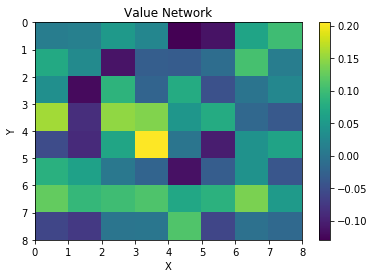

In [82]:
actor, critic = actor_critic.trainer(epochs=2000)

In [94]:
actor_critic_ws=ACTOR_CRITIC(env=env,warm_start=200)

/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform", input_shape=(64,))`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="lecun_uniform")`
/anaconda/envs/drl/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="lecun_uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_81 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 5         
_________________________________________________________________
activation_82 (Activation)   (None, 1)                 0         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_8

In [92]:
policy = toy.sample_generator(1)

[[u'v' u'v' u'<' u'<' u'<' u'<' u'v' u'<']
 [u'v' u'v' u'<' u'<' u'<' u'<' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'v' u'<' u'<' u'<']
 [u'v' u'<' u'v' u'<' u'v' u'v' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'v' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']]


Game #: 205
Moves this round 1
Final Position:
  (Up)
FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF
Wins/Losses 14/192
Wins/Losses before WS 14/186
Goal reached!
[[u'>' u'<' u'<' u'>' u'<' u'>' u'>' u'<']
 [u'<' u'<' u'<' u'>' u'<' u'<' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'>' u'<' u'<' u'^']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'>' u'<' u'<' u'>' u'^' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'v' u'<' u'<' u'<' u'<' u'>']]
[[2. 0. 0. 2. 0. 2. 2. 0.]
 [0. 0. 0. 2. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 2. 0. 0. 3.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 2. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 2.]]
0.0
Converged


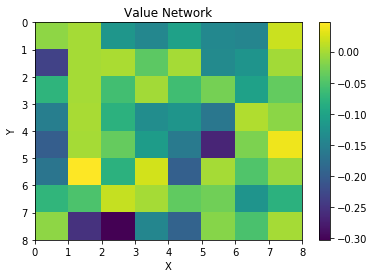

In [95]:
actor_ws, critic_ws = actor_critic_ws.trainer(epochs=2000,epsilon=0.5,policy=policy)

Game #: 378
Moves this round 5
Final Position:
  (Down)
FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF
Wins/Losses 40/339
Wins/Losses before WS 22/78
Goal reached!
[[u'<' u'^' u'^' u'<' u'^' u'^' u'<' u'<']
 [u'<' u'v' u'<' u'>' u'v' u'>' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'>' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'^' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'^' u'v' u'<' u'<']
 [u'<' u'v' u'v' u'v' u'v' u'<' u'>' u'<']
 [u'^' u'<' u'>' u'<' u'<' u'<' u'v' u'^']]
Policy Done


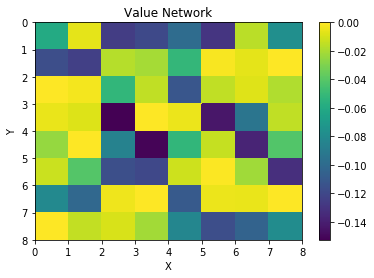

In [42]:
actor_ws, critic_ws = actor_critic_ws.trainer(epochs=1000,epsilon=0.5,policy=policy)

## The Critic

## Plotting 

In [16]:
# Plot out the values the critic gives for the agent being in
# a specific state, i.e. in a specific location in the env.
def plot_value(critic_model):
    # Assume gridworld is always a square
    initial_state = np.zeros((8,8))
    obs_sqr = math.sqrt(64)
    np_w_cri_r = np.zeros((8,8))
    # make a working copy.
    working_state = initial_state.copy()
    for x in range(0,8):
        for y in range(0,8):
            my_state = working_state.copy()
            # Place the player at a given X/Y location.
            my_state[x,y] = 1
            # And now have the critic model predict the state value
            # with the player in that location.
            value = critic_model.predict(my_state.reshape(1, 64))
            np_w_cri_r[x,y] = value
    np_w_cri_r.shape
    pylab.pcolor(np_w_cri_r)
    pylab.title("Value Network")
    pylab.colorbar()
    pylab.xlabel("X")
    pylab.ylabel("Y")
    pylab.gca().invert_yaxis()
    pylab.draw()


FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF


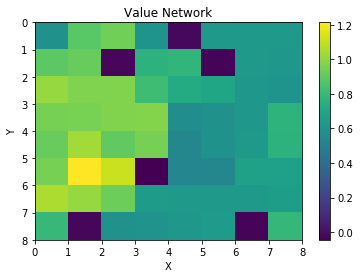

In [96]:
env.reset()
env.render()
plot_value(critic_ws)


FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF


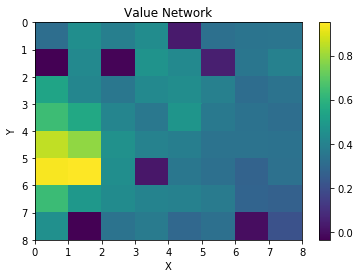

In [83]:
env.reset()
env.render()
plot_value(critic)

In [23]:
def show_policy(actor_model):
    initial_state = np.zeros((8,8))
    A2A=['<','v','>','^']
    grid = np.zeros((8,8), dtype='<U2')
    for x in range(0,8):
        for y in range(0,8):
            my_state = initial_state.copy()
            my_state[x,y] = 1
            obs_predict = my_state.reshape(1,64,)
            qval = actor_model.predict(obs_predict)
            action = (np.argmax(qval))
            grid[x,y] = A2A[action]
    grid
    return grid

In [27]:
def make_policy(actor_model):
    initial_state = np.zeros(64)
    grid = np.zeros(64)
    for x in range(0,64):
        my_state = initial_state.copy()
        my_state[x] = 1
        obs_predict = my_state.reshape(1,64,)
        qval = actor_model.predict(obs_predict)
        action = (np.argmax(qval))
        grid[x] = action
    grid
    return grid

In [28]:
make_policy(actor)

array([0., 0., 2., 0., 2., 3., 2., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 0., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 0., 2., 2.])

In [98]:
categorical_labels = to_categorical(make_policy(actor), num_classes=4)
print(categorical_labels)

(64, 4)


In [84]:
env.reset()
env.render()
print(show_policy(actor))


FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF
[[u'<' u'v' u'<' u'<' u'<' u'^' u'v' u'v']
 [u'v' u'v' u'<' u'^' u'v' u'v' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'v' u'<' u'<' u'<']
 [u'<' u'v' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'v' u'<' u'v' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'v' u'v' u'<' u'v' u'<' u'<' u'^']]


In [97]:
env.reset()
env.render()
print(show_policy(actor_ws))


FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF
[[u'>' u'<' u'<' u'>' u'<' u'>' u'>' u'<']
 [u'<' u'<' u'<' u'>' u'<' u'<' u'v' u'<']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'v' u'<' u'<' u'<' u'>' u'<' u'<' u'^']
 [u'v' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'>' u'<' u'<' u'>' u'^' u'<' u'<']
 [u'<' u'<' u'<' u'<' u'<' u'<' u'<' u'<']
 [u'<' u'<' u'v' u'<' u'<' u'<' u'<' u'>']]


### Showing Policy

In [86]:
def play(env,actor_model,render_every_step=False):
    observation = env.reset()
    done = False
    reward = 0.0
    max_moves = 40
    move_counter = 0
    while not done and move_counter < max_moves:
        state = toy.to_onehot(64,observation)
        qval = actor_model.predict( state.reshape(1,64) )
        action = (np.argmax(qval))
        observation, reward, done, info = env.step(action)
        if render_every_step:
            env.render()
        move_counter += 1
    if reward==1.0:
        print("Goal reached!")
    env.render()

In [87]:
play(env,actor)

Goal reached!
  (Down)
FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF


In [98]:
play(env,actor_ws)

Goal reached!
  (Down)
FFFFHFFF
HFHFFHFS
FFFFFFFF
FFFFFFFF
FFFFFFFF
GFFHFFFF
FFFFFFFF
FHFFFFHF


## IDEAS

In [25]:
discriminator = load_model('models/policies/discriminator.h5')

In [100]:
discriminator.predict(np.expand_dims(policy,axis=0))[0][0]

0.26046354

In [146]:
show_policy(actor_ws)

array([[u'<', u'<', u'<', u'v', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'<', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'<', u'^', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'^', u'<', u'<', u'^', u'<'],
       [u'<', u'<', u'<', u'<', u'v', u'<', u'<', u'<'],
       [u'<', u'<', u'<', u'^', u'<', u'<', u'<', u'<'],
       [u'^', u'v', u'<', u'<', u'<', u'<', u'<', u'v']], dtype='<U2')

In [106]:
discriminator.predict(np.expand_dims(categorical_labels,axis=0))[0][0]

NameError: name 'categorical_labels' is not defined

In [99]:
discriminator.predict(np.expand_dims(np.random.randint(2, size=(64, 4)),axis=0))[0][0]

0.0

In [108]:
discriminator.predict(np.expand_dims(to_categorical(make_policy(actor_ws)),axis=0))

array([[6.654189e-11]], dtype=float32)